In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import KFold
import gc

import warnings
warnings.filterwarnings(action = 'ignore')

In [10]:
df_train = pd.read_csv('train.csv')

In [11]:
df_train.shape

(10886, 12)

In [12]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [13]:
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

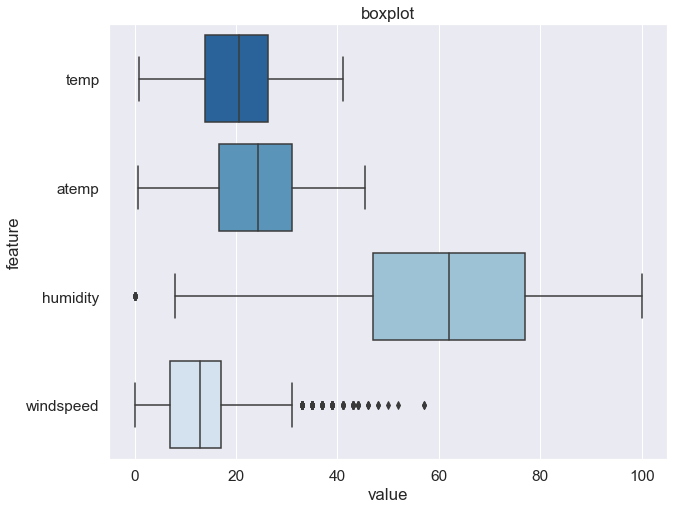

In [14]:
melt = pd.melt(df_train,value_vars=df_train.drop(['datetime','casual','registered','count','holiday','workingday', 'weather','season'], axis =1).columns, 
               var_name =['feature'],value_name = 'value')

plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)
sns.boxplot(data = melt, y = 'feature',x='value', palette="Blues_r").set(ylabel = 'feature',title = 'boxplot');

In [15]:
def time_transform(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    
    return df

df_train = time_transform(df_train)

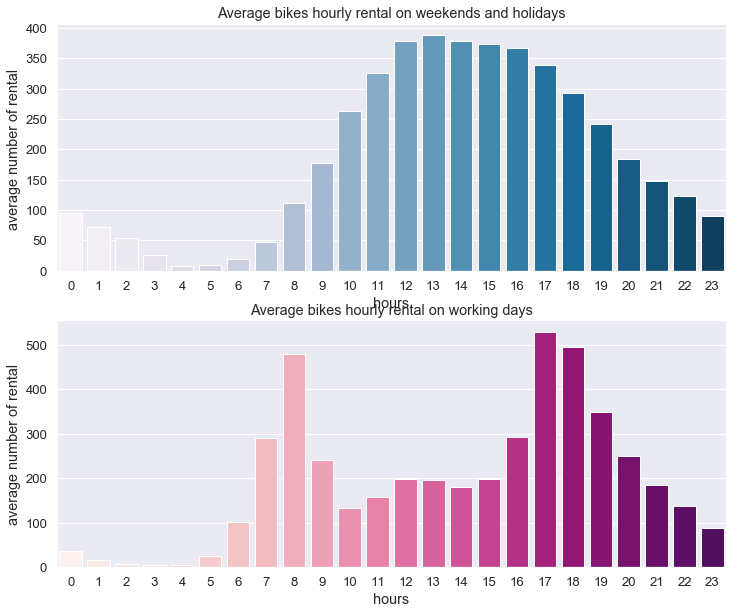

In [21]:
#Comparison hourly rental for working days with days off.

fig, ax = plt.subplots(2,1,figsize =(12,10))
sns.set(font_scale=1.2)

sns.barplot(x = df_train['hour'].unique(),
            y= df_train['count'].loc[df_train['workingday']==0].groupby(df_train['hour']).mean(),
           ax = ax[0], palette= 'PuBu').set(title = 'Average bikes hourly rental on weekends and holidays',
                                            xlabel = 'hours', ylabel = 'average number of rental ')
sns.barplot(x = df_train['hour'].unique(),
            y= df_train['count'].loc[df_train['workingday']==1].groupby(df_train['hour']).mean(),
           ax = ax[1], palette='RdPu').set(title='Average bikes hourly rental on working days',
                                          xlabel = 'hours',ylabel = 'average number of rental');


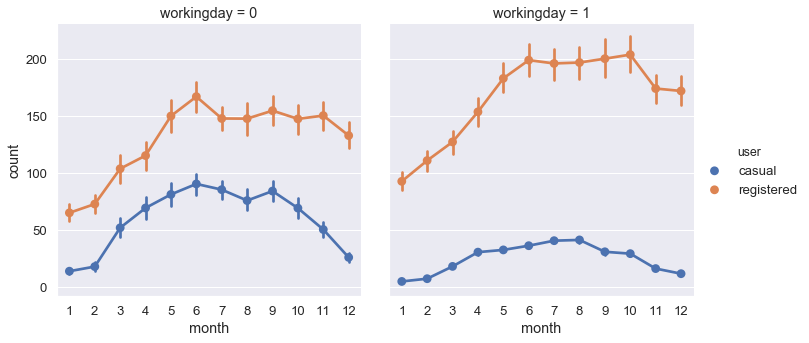

In [22]:
user_table = pd.melt(df_train, id_vars = ['month','workingday'],value_vars = df_train[['casual','registered']],
               var_name = 'user', value_name = 'count')

plot = sns.factorplot(x = 'month',y = 'count',data = user_table,col = 'workingday',
                      hue = 'user',height = 5);


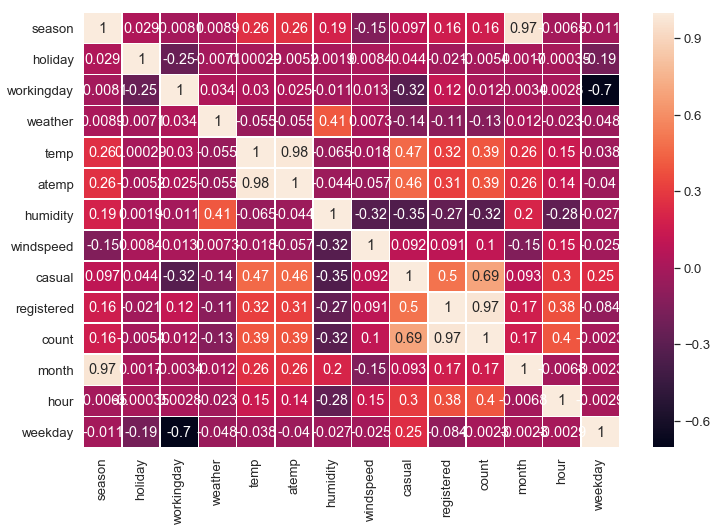

In [23]:
#heatmeap
plt.figure(figsize=(12,8))
sns.set(font_scale=1.2)
sns.heatmap(data = df_train.corr(), annot=True, linewidths=0.5);

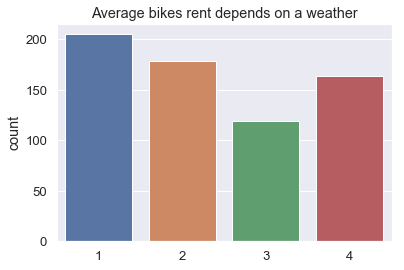

In [24]:
fix = plt.subplots(figsize = (6,4))
plt.title("Average bikes rent depends on a weather")
plt.ylabel('weather')
sns.barplot(x = df_train['weather'].unique(),y = df_train['count'].groupby(df_train['weather']).mean());

In [25]:
features = df_train.drop(columns =['datetime','casual','registered','count','holiday'])

In [26]:
target = np.log1p(df_train['count'])

In [27]:
categorical_features = ['workingday','weather', 'season']

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}
kf = KFold(n_splits=2)
models = []
for train_index,test_index in kf.split(features):
    
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,
                             categorical_feature=categorical_features, 
                             free_raw_data=False)
    
    d_test = lgb.Dataset(test_features, label=test_target,
                         categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, 
                         valid_sets=[d_training,d_test], 
                         verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()



Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.566277	valid_1's rmse: 0.78457
[50]	training's rmse: 0.293342	valid_1's rmse: 0.63903
[75]	training's rmse: 0.220705	valid_1's rmse: 0.619297
[100]	training's rmse: 0.191502	valid_1's rmse: 0.617126
[125]	training's rmse: 0.173085	valid_1's rmse: 0.618512
[150]	training's rmse: 0.159189	valid_1's rmse: 0.620447
Early stopping, best iteration is:
[101]	training's rmse: 0.190551	valid_1's rmse: 0.617035
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.56349	valid_1's rmse: 0.800461
[50]	training's rmse: 0.310261	valid_1's rmse: 0.622614
[75]	training's rmse: 0.240876	valid_1's rmse: 0.588247
[100]	training's rmse: 0.210955	valid_1's rmse: 0.579967
[125]	training's rmse: 0.191035	valid_1's rmse: 0.578328
[150]	training's rmse: 0.176021	valid_1's rmse: 0.577888
[175]	training's rmse: 0.163537	valid_1's rmse: 0.578595
Early stopping, best iteration is:
[148]	training's rm

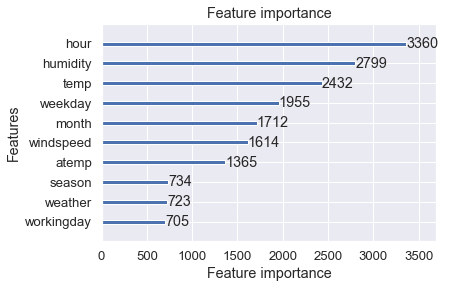

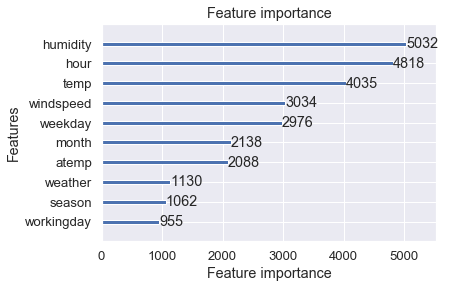

In [28]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [29]:
df_test = pd.read_csv('test.csv')

In [30]:
df_test = time_transform(df_test)

In [31]:
test = df_test.drop(columns=['datetime','holiday'])

In [32]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

In [33]:
result_df = pd.DataFrame({'datetime':df_test['datetime'],'count':results})
result_df.to_csv("submission.csv",index = False)